In [1]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt

from alpha_vantage.timeseries import TimeSeries
# get API Key from https://www.alphavantage.co/
alphavantage_api_key=""


In [2]:
torch.manual_seed(34)

# Retrieve data from Alpha Vantage

Don't bother with this step if the data's already saved from the Pickle below.

In [3]:
def get_daily_adjusted (symbol, nickname=""):
    if len(nickname) > 0:
        nickname = "_"+nickname
    ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
    data=data.rename(index=str, columns={"date":"Date","1. open": "Open"+nickname, "2. high": "High"+nickname, "3. low":"Low"+nickname, "4. close":"Close"+nickname, "5. adjusted close":"Adj. Close"+nickname, "6. volume":"Volume"+nickname, "7. dividend amount":"Dividend"+nickname, "8. split coefficient":"Split Ratio"+nickname})
    data.index = pd.to_datetime(data.index)
    data.index.names = ['Date']
    return data

In [4]:
aapl = get_daily_adjusted("AAPL")
msft = get_daily_adjusted("MSFT")

In [19]:
aapl.head()

,Open,High,Low,Close,Adj. Close,Volume,Dividend,Split Ratio
Date,,,,,,,,
1998-01-02,13.63,16.25,13.50,16.25,0.5103,6411700.0,0.0,1.0
1998-01-05,16.50,16.56,15.19,15.88,0.4987,5820300.0,0.0,1.0
1998-01-06,15.94,20.00,14.75,18.94,0.5948,16182800.0,0.0,1.0
1998-01-07,18.81,19.00,17.31,17.50,0.5496,9300200.0,0.0,1.0
1998-01-08,17.44,18.62,16.94,18.19,0.5713,6910900.0,0.0,1.0


In [20]:
msft.head()

,Open,High,Low,Close,Adj. Close,Volume,Dividend,Split Ratio
Date,,,,,,,,
1998-01-02,129.63,131.50,129.50,131.13,10.7255,4968500.0,0.0,1.0
1998-01-05,131.25,133.63,127.87,130.38,10.6642,10047200.0,0.0,1.0
1998-01-06,129.75,133.00,129.25,131.13,10.7255,8479300.0,0.0,1.0
1998-01-07,129.88,131.19,127.50,129.56,10.5971,7686600.0,0.0,1.0
1998-01-08,128.63,132.13,127.50,130.50,10.6740,9702400.0,0.0,1.0


## Examine the data

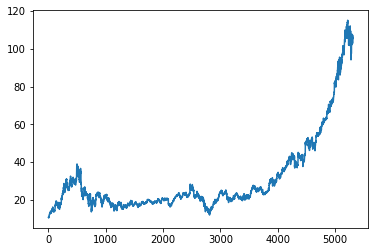

In [21]:
plt.plot(range(0, len(msft["Adj. Close"])), msft["Adj. Close"])

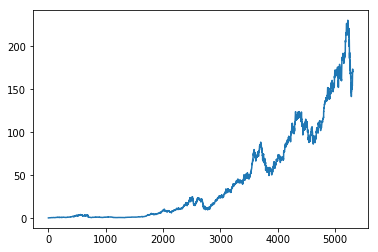

In [22]:
plt.plot(range(0, len(aapl["Adj. Close"])), aapl["Adj. Close"])

## Remove the general upwards trend.

Now I'm going to de-trend the data. Otherwise MSFT and AAPL are on completely different scales and we could hardly expect the AI to learn how to trade apples and oranges together. Additionally, we want the AI to learn the fundamentals of the stock signal - buy if it's going to rise. If we didn't remove the trend, maybe it'd only learn to buy at the start and hold til the end since a general upwards trend happens.

SciPy's signal processing module has a function that fits a linear least-squares model to the data and subtracts it for us.

In [11]:
from scipy import signal

In [29]:
msft = msft['2014-01-01':]
msft_close_detrended = signal.detrend(msft["Adj. Close"])

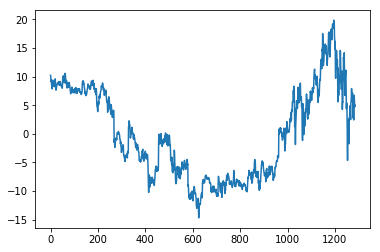

In [30]:
plt.plot(range(0,len(msft_close_detrended)), msft_close_detrended)

In [31]:
msft_close_detrended_df = pd.DataFrame(index = msft.index, data = msft_close_detrended, columns=["Adj. Close"])

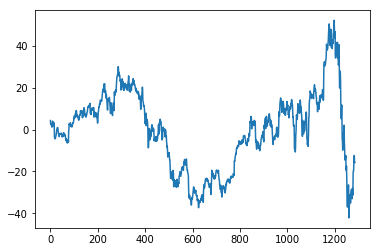

In [32]:
aapl = aapl['2014-01-01':]
aapl_close_detrended = signal.detrend(aapl["Adj. Close"])
plt.plot(range(0,len(aapl_close_detrended)), aapl_close_detrended)

In [33]:
aapl_close_detrended_df = pd.DataFrame(index = aapl.index, data = aapl_close_detrended, columns=["Adj. Close"])

## Negative values?

It doesn't make sense to buy a share at a negative value. But since the model will learn to maximize reward, we can just shift it up by a constant number so it's always positive.

In [34]:
print(msft_close_detrended_df["Adj. Close"].min())
print(aapl_close_detrended_df["Adj. Close"].min())

-14.700703607472342
-42.18154263124123


Choose 43

In [36]:
adj = 43
apl_close += adj
msf_close += adj

In [37]:
apl_train, apl_test = aapl[:'2018-08-20'], aapl['2018-08-21':]
msf_train, msf_test = msft[:'2018-08-20'], msft['2018-08-21':]

In [39]:
print(len(apl_train) == len(msf_train))
print(len(apl_test) == len(msf_test))

True
True


In [45]:
apl_close = apl_train["Adj. Close"].values
msf_close = msf_train["Adj. Close"].values

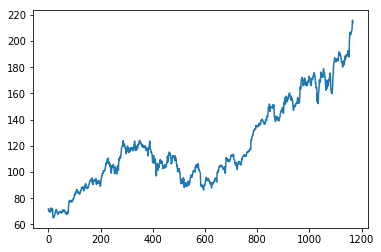

In [46]:
plt.plot(range(0,len(apl_close)), apl_close)

## Save the transformed data

In [47]:
import pickle
with open("aplmsfopenclose.pkl", "wb+") as f:
    pickle.dump({"ac": apl_close, "mc": msf_close}, f)

## If the data's already saved, skip the above and load it here instead

In [48]:
import pickle
with open("aplmsfopenclose.pkl", "rb") as f:
    d = pickle.load(f)

apl_close = d["ac"]
msf_close = d["mc"]

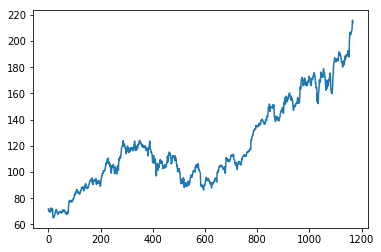

In [49]:
plt.plot(range(0,len(apl_close)), apl_close)

# Build the environment

* <b>I changed the environment to act/transact based on closing price instead of opening price.  The value of closing price is more reliable/stable/rigor then opening price.  The original algorithm act/transact based on opening price and calculates portofolio based on closing price.</b>
* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each closing price should be 43, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl close [3], today msf close [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee
<br>
<li><b>TODO:</b>
    <ol>
        <li>In step function, change gain calculation to be based on future unrealized gains/loses, original code "gain = cur_value - self.starting_portfolio_value" seems to be calculating cumulative gains based on past actions.</li>
        <li>Calculate portfolio value based on actual undetrended closing prices</li>
        <li>Determine if reward should be calculated based on inaction_penalty-ts_left+gain</li>
        <li>Fix how bankrupt state is calculated.  Should be when portfolio value &lt; 0</li>
        <li>Introduce short sell and interest rate for holding short position</li>
    </ol>
</li>

In [51]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, \
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        #self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.state = torch.FloatTensor(torch.zeros(8))
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_close[self.cur_timestep]
        self.state[4] = msf_close[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_closing_price(self):
        step = self.cur_timestep + self.stride
        return [apl_close[step], msf_close[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_close[0], msf_close[0]]
        apl5 = apl_close[step-5:step].mean()
        msf5 = msf_close[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}

        # Do nothing
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        #Buy AAPL
        if action[0] == 0:
            if action[1] * apl_close[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_close[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_closing_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        # Buy MSFT        
        if action[0] == 3:
            # not enough cash to buy 1 share of MSFT
            if action[1] * msf_close[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                # TODO why is this the bankrupt state?  Shouldn't bankrupt state = true when portfolio value < 0?
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"} 
            else:
                # TODO why is action[1] hard coded to 1?
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_close[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_closing_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                # TODO why is the reward calculated as inaction_penalty-ts_left+gain?
                # gain is calculated based on the performance of past ations, shouldn't it be based on the value of current action?
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        
        # Sell AAPL
        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_close[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_closing_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        # Sell MSFT        
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_closing_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_close[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_closing_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        #self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.state = torch.FloatTensor(torch.zeros(8))
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_close[self.cur_timestep]
        self.state[4] = msf_close[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [52]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        #self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.hidden_state = torch.tensor(torch.zeros(2,1,32))
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        #self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.hidden_state = torch.tensor(torch.zeros(2,1,32))
        
    def forward(self, x):
        #x = torch.tensor(x).cuda()
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        #if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        #if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [53]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

C:\ProgramData\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [55]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        #reward = torch.tensor(r - value.item()).cuda()
        reward = torch.tensor(r - value.item())
        policy_losses.append(-log_prob * reward)
        #value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r])))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 4000):
#for episode in range(0, 1):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    i=0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

C:\ProgramData\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 11445.1, finished at 22303.0 because bankrupted self @ t=961, last reward 6076.0, running reward 101.3
Early Stopping: 36695


## Let's see how it does in practice, on the training data

In [56]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 50

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

C:\ProgramData\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Failed goes: 46 / 50, Avg Rewards per successful game: 23630.791015625
Avg % profit per game: 0.5155870914459229
Avg % profit per finished game: 6.444839000701904


## And here's how a sample trading run might look

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

In [ ]:
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_open_orig[:108] /= 7
apl_close_orig[:108] /= 7

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

In [ ]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

In [ ]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")